### We compare my spergel results with Greco+18 Sersic results

In [158]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [4]:
lsbg_cat = Table.read('./Catalog/candy/candy_cutout_cat_candy.fits')

imcomplete_file_ind = np.sort(lsbg_cat[~np.all(lsbg_cat['image_flag'].data, axis=1)]['viz-id'].data)
print('Number of incomplete files:', len(imcomplete_file_ind))

print('Valid number of objects:', len(lsbg_cat) - len(imcomplete_file_ind))

Number of incomplete files: 4
Valid number of objects: 777


### The measurement is done by running `sbatch 1k_meas.slurm`, etc. Check `vanilla_measure_all.py` for details.

The measurement catalogs are saved at `./Catalog/NSA/z002_004/lsbg_measure_vaniila_XXXXX.fits`.

Below, we combine these catalogs together.

---
### Analysis: make cuts to rule out junks. START HERE!

In [209]:
import kuaizi
from kuaizi.display import plot_measurement
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='JL', usetex=True, dpi=70, fontsize=17)

---
### Load Spergel catalog, apply mask, plot properties

In [7]:
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')
from sample_cuts import make_cuts_spergel

In [174]:
suffix = 'nosegmap'
method = 'spergel'

meas_cat = Table.read(f'./Catalog/candy/{method}/lsbg_meas_{method}_{suffix}_all.fits')
meas_cat.sort('ID')
assert np.all(meas_cat['ID'] == lsbg_cat['viz-id']), "Two catalogs do not match!"

cuts_cat = hstack([lsbg_cat, meas_cat])

# Additional step: remove large R_e in spergel
flag = make_cuts_spergel(cuts_cat)
cuts_cat = cuts_cat[flag]

cuts_cat['rhalf_spergel'] = 0.168 * cuts_cat['rhalf_spergel']
cuts_cat['rhalf_circularized'] = 0.168 * cuts_cat['rhalf_circularized']
cuts_cat['sersic_rhalf'] = 0.168 * cuts_cat['sersic_rhalf']

cuts_cat['Reff'] = cuts_cat['Reff'] * np.sqrt(1 - cuts_cat['Ell'])
cuts_cat['e_Reff'] = cuts_cat['e_Reff'] * np.sqrt(1 - cuts_cat['Ell'])

print('Number of objs after junk cuts', len(cuts_cat))

Number of objs after junk cuts 754


In [275]:
diff = cuts_cat['rhalf_spergel'] - cuts_cat['Reff']
np.where(np.abs(diff) > 2)

(array([ 19,  88,  93, 186, 189, 251, 267, 299, 300, 302, 343, 424, 438,
        453, 583, 612, 633, 634, 674, 725, 744]),)

In [278]:
np.where(diff > 1.5)

(array([ 16,  19,  88,  92, 196, 240, 252, 336, 363, 522, 590, 633, 634,
        674, 690, 719, 730, 744]),)

Text(0, 0.5, '$R_e$ (Spergel) - $R_e$ (Greco)')

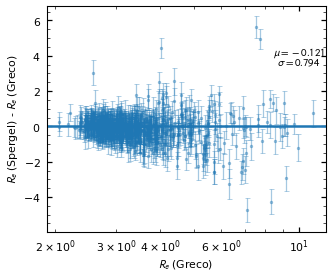

In [182]:
diff = cuts_cat['rhalf_spergel'] - cuts_cat['Reff']
plt.errorbar(cuts_cat['Reff'], 
             diff,
             yerr=cuts_cat['e_Reff'], fmt='o', markersize=3, alpha=0.4)#, edgecolors='none', s=10)
plt.axhline(0, lw=3)
plt.text(10, 4, f'$\mu = {np.mean(diff):.3f}$', ha='center')
plt.text(10, 3.4, f'$\sigma = {np.std(diff):.3f}$', ha='center')
plt.xscale('log')
plt.xlabel('$R_e$ (Greco)')
plt.ylabel('$R_e$ (Spergel) - $R_e$ (Greco)')

In [191]:
np.sum(np.abs(diff) < cuts_cat['e_Reff']) / len(diff)

0.7625994694960212

Text(0, 0.5, '$R_e$ (Spergel) - $R_e$ (Greco)')

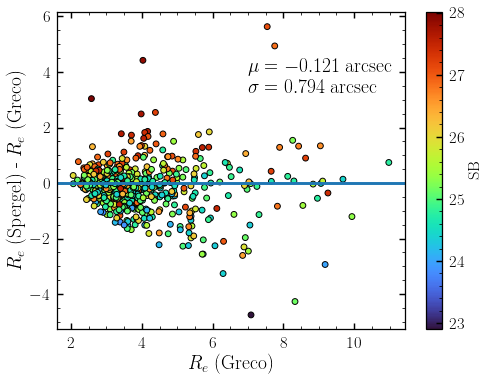

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
diff = cuts_cat['rhalf_spergel'] - cuts_cat['Reff']
plt.scatter(cuts_cat['Reff'], 
            diff, 
            c=cuts_cat['SB_eff_avg'][:, 0])#, edgecolors='none', s=10)
plt.axhline(0, lw=3)
plt.colorbar(label='SB')
plt.text(7, 4, f'$\mu = {np.mean(diff):.3f}$ arcsec', ha='left', fontsize=20)
plt.text(7, 3.2, f'$\sigma = {np.std(diff):.3f}$ arcsec', ha='left', fontsize=20)

plt.xlabel('$R_e$ (Greco)', fontsize=20)
plt.ylabel('$R_e$ (Spergel) - $R_e$ (Greco)', fontsize=20)

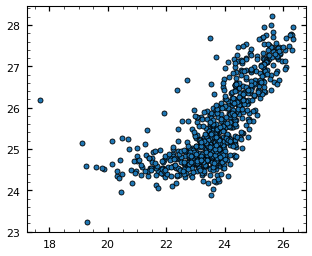

In [100]:
plt.scatter(cuts_cat['iSB'], cuts_cat['SB_eff_avg'][:, 0])

0.0789096002453391
0.3442045834893495


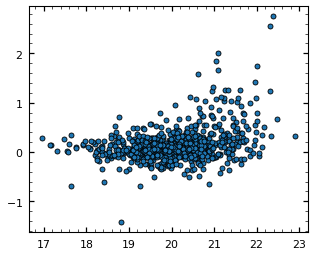

In [95]:
plt.scatter(cuts_cat['mag_auto_i'], cuts_cat['mag_auto_i'] - cuts_cat['mag'][:, 2])
print(np.median(cuts_cat['mag_auto_i'] - cuts_cat['mag'][:, 2]))
print(np.std(cuts_cat['mag_auto_i'] - cuts_cat['mag'][:, 2]))

-0.0009057847727054202
0.09462913730475475


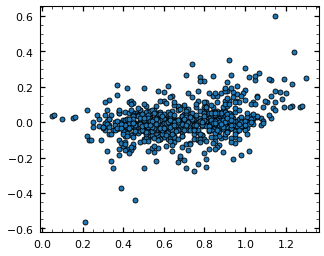

In [9]:
plt.scatter(cuts_cat['g-i'], 
            cuts_cat['g-i'] - (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 2]))
print(np.median(cuts_cat['g-i'] - (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 2])))
print(np.std(cuts_cat['g-i'] - (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 2])))

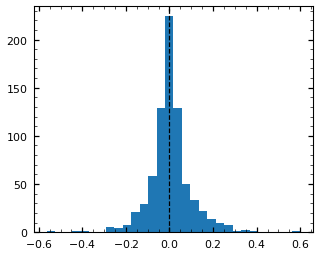

In [90]:
plt.hist(cuts_cat['g-i'] - (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 2]), bins=30)
plt.axvline(0, ls='--', color='k')

In [ ]:
(array([ 19,  88,  93, 186, 189, 251, 267, 299, 300, 302, 343, 424, 438,
        453, 583, 612, 633, 634, 674, 725, 744]),)

In [ ]:
(array([ 16,  19,  88,  92, 196, 240, 252, 336, 363, 522, 590, 633, 634,
        674, 690, 719, 730, 744]),)

In [318]:
ind = 196 #251 #189
vizid = cuts_cat[ind]['viz-id']

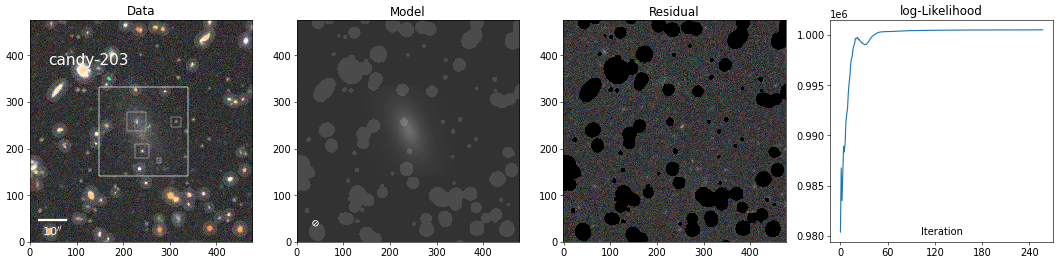

In [319]:
method = 'spergel'
Image.open(f'./Figure/candy/{method}/candy-{vizid}-zoomin-{method}.png')

In [320]:
cuts_cat[ind][['viz-id', 'Reff', "e_Reff", 'n', 'Ell', 
               'rhalf_spergel', 'rhalf_circularized', 
               "ell_sym", 'sersic_rhalf', 'sersic_n']
             ]

viz-id,Reff,e_Reff,n,Ell,rhalf_spergel,rhalf_circularized,ell_sym,sersic_rhalf,sersic_n
,arcsec,arcsec,,,,,,,
int16,float64,float64,float64,float64,float64,float64,float64,float64,float64
203,5.598879887977594,0.571314274283428,0.63,0.49,7.347716671957377,6.723910111927051,0.36208101498748,9.114391144099915,0.7362766259652248


In [321]:
import dill

In [322]:
with open(f'./Model/candy/spergel/candy-{vizid}-trained-model-spergel.df', 'rb') as fp:
    [blend, info, footprint] = dill.load(fp)
    fp.close()

In [328]:
from kuaizi.measure import nu_to_n
nu_to_n(blend.sources[0].parameters[2])

Parameter([[0.80736444]])

In [325]:
mask = (footprint | (np.sum(blend.observations[0].weights == 0, axis=0) != 0))

In [326]:
fits.PrimaryHDU(data=mask.astype(float)).writeto(f'./test_mask_{vizid}.fits', overwrite=True)

In [327]:
print("rsync -avz jiaxuanl@tiger.princeton.edu:" + 
      f'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/candy/candy_{vizid}_i.fits' + ' ./data/')
print("rsync -avz jiaxuanl@tiger.princeton.edu:" + 
      f'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/candy/candy_{vizid}_i_psf.fits' + ' ./data/')
print("rsync -avz jiaxuanl@tiger.princeton.edu:" + 
      f'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/test_mask_{vizid}.fits' + ' ./data/')

rsync -avz jiaxuanl@tiger.princeton.edu:/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/candy/candy_203_i.fits ./data/
rsync -avz jiaxuanl@tiger.princeton.edu:/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/candy/candy_203_i_psf.fits ./data/
rsync -avz jiaxuanl@tiger.princeton.edu:/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/test_mask_203.fits ./data/
